In [1]:
import mytorch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
FILE_PATH = '/mnt/DE0A83560A832B1B/UNI/T6/Computational Intelgence/P1/wdbc.data'

In [3]:
column_names = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
df = pd.read_csv(FILE_PATH, header=None, names=column_names, usecols=range(1, 32))

df["Diagnosis"] = df["Diagnosis"].map({"M": 1, "B": 0})

df.describe()

,Diagnosis,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [4]:
X = df.drop(columns=["Diagnosis"]).values
y = df["Diagnosis"].values

Xy = np.concatenate((X, y.reshape(-1, 1)), axis=1)
np.random.shuffle(Xy)

n_data = Xy.shape[0]
n_train = int(0.8 * n_data)
n_test = n_data - n_train

train = Xy[:n_train, :]
test = Xy[n_train:, :]

X_train = train[:, :-1]
y_train = train[:, -1].reshape(-1, 1)
X_test = test[:, :-1]
y_test = test[:, -1].reshape(-1, 1)

In [5]:
import mytorch.util as KOMAK

train_loader = KOMAK.DataLoader(X_train, y_train, 64)
test_loader = KOMAK.DataLoader(X_test, y_test, 64)

In [6]:
from mytorch.activation import *
from mytorch.layer import *


class MLP(mytorch.Model):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.l1 = Linear(input_size, 100, need_bias=True)
        self.l2 = Linear(100, 50, need_bias=True)
        self.l3 = Linear(50, 1, need_bias=True)
        
        
        
    def forward(self, x):
        x = relu(self.l1(x))
        x = relu(self.l2(x))
        x = sigmoid(self.l3(x))
        return x

In [7]:
import mytorch.loss as loss
import mytorch.optimizer as opt


input_size = 30
model = MLP(input_size)


criterion = loss.CategoricalCrossEntropy
optimizer = opt.SGD(model.parameters(), learning_rate=0.001)
NUM_EPOCHS = 100

In [8]:
train_accuracy_list= []
test_accuracy_list= []

for epoch in range(NUM_EPOCHS):
    total=0
    corrects= 0
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = mytorch.Tensor(inputs)
        labels = mytorch.Tensor(labels)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data.item() 
        total += labels.data.size 
        predicted = (outputs.data > 0.5)
        corrects += (predicted == labels.data).sum().item()

    accuracy= corrects / total
    train_accuracy_list.append(accuracy)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {(running_loss / len(train_loader)):.4f}, Acurracy= {accuracy:.4f}")

    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = mytorch.Tensor(inputs)
        labels = mytorch.Tensor(labels)
        outputs = model(inputs)
        predicted = (outputs.data > 0.5) 
        correct += (predicted == labels.data).sum().item() 
        total += labels.data.size

    accuracy = correct / total
    test_accuracy_list.append(accuracy)
    print(f"Test Accuracy: {accuracy:.4f}", end="\n\n")

Epoch 1/100, Loss: 3.3733, Acurracy= 0.5143
Test Accuracy: 0.5702

Epoch 2/100, Loss: 1.5433, Acurracy= 0.5253
Test Accuracy: 0.4298

Epoch 3/100, Loss: 1.0230, Acurracy= 0.5516
Test Accuracy: 0.7368

Epoch 4/100, Loss: 0.7308, Acurracy= 0.5868
Test Accuracy: 0.4298

Epoch 5/100, Loss: 0.6549, Acurracy= 0.4989
Test Accuracy: 0.5965

Epoch 6/100, Loss: 0.5707, Acurracy= 0.7011
Test Accuracy: 0.9035

Epoch 7/100, Loss: 0.4778, Acurracy= 0.8308
Test Accuracy: 0.5789

Epoch 8/100, Loss: 0.4909, Acurracy= 0.8879
Test Accuracy: 0.7895

Epoch 9/100, Loss: 0.5959, Acurracy= 0.7033
Test Accuracy: 0.4298

Epoch 10/100, Loss: 0.5668, Acurracy= 0.7582
Test Accuracy: 0.8333

Epoch 11/100, Loss: 0.4664, Acurracy= 0.8264
Test Accuracy: 0.5965

Epoch 12/100, Loss: 0.7188, Acurracy= 0.7143
Test Accuracy: 0.9123

Epoch 13/100, Loss: 0.4244, Acurracy= 0.8396
Test Accuracy: 0.9211

Epoch 14/100, Loss: 0.4486, Acurracy= 0.8835
Test Accuracy: 0.4298

Epoch 15/100, Loss: 0.4776, Acurracy= 0.8264
Test Accurac

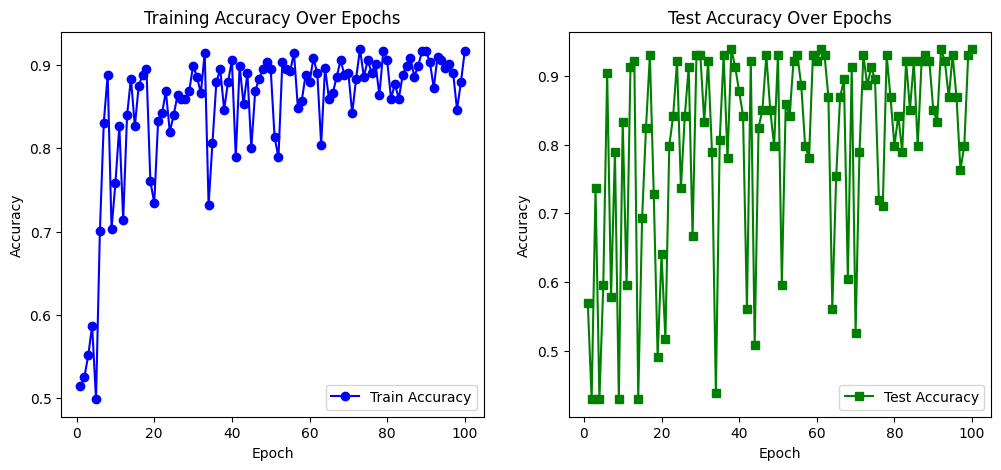

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_accuracy_list, marker='o', linestyle='-', color='b', label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), test_accuracy_list, marker='s', linestyle='-', color='g', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()

plt.show()